In [1]:
def plot_top_conversion_rates(df, category_col, target_col, top_n=10):
    
    # 각 범주별로 target_col의 True와 False의 개수를 집계
    conversion_counts = df.groupby([category_col, target_col]).size().unstack(fill_value=0)

    # True 비율
    conversion_rates = conversion_counts.div(conversion_counts.sum(axis=1), axis=0)

    # True 비율이 높은 상위 N개 범주를 선택
    top_categories = conversion_rates[True].sort_values(ascending=False).head(top_n).index

    top_conversion_rates = conversion_rates.loc[top_categories]

    ax = top_conversion_rates.plot(kind='bar', stacked=True, figsize=(10, 5))

    plt.title(f'Top {top_n}')
    plt.xlabel(category_col)
    plt.ylabel('Conversion Rate')
    plt.xticks(rotation=45)
    plt.legend(title=target_col, labels=['False', 'True'])

    # 그래프 표시
    plt.tight_layout()
    plt.show()


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier



from category_encoders import TargetEncoder


import seaborn as sns
import matplotlib.pyplot as plt


from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier


In [4]:
df_train = pd.read_csv("df_train.csv", index_col=0) # 학습용 데이터
df_test = pd.read_csv("df_test.csv", index_col=0) # 테스트 데이터(제출파일의 데이터)

In [5]:
df_train.isnull().sum()

bant_submit                0
customer_country           0
business_unit              0
com_reg_ver_win_rate       0
customer_idx               0
customer_type              0
enterprise                 0
historical_existing_cnt    0
id_strategic_ver           0
it_strategic_ver           0
idit_strategic_ver         0
customer_job               0
lead_desc_length           0
inquiry_type               0
product_category           0
product_subcategory        0
customer_position          0
response_corporate         0
expected_timeline          0
ver_cus                    0
ver_pro                    0
ver_win_ratio_per_bu       0
lead_owner                 0
is_converted               0
dtype: int64

In [6]:
df_train.head()

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,product_category,product_subcategory,customer_position,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_ratio_per_bu,lead_owner,is_converted
0,1.0,0.081789,0.081789,0.066667,0.081789,0.081789,0.081789,4.0,0.0,0.0,...,0.081789,0.081789,0.081789,0.081789,0.081789,1,0,0.026846,0.081789,True
1,1.0,0.540894,0.540894,0.066667,0.540894,0.540894,0.540894,12.0,0.0,0.0,...,0.540894,0.540894,0.081789,0.540894,0.540894,1,0,0.026846,0.081789,True
2,1.0,0.081789,0.693930,0.088889,0.693930,0.693930,0.693930,144.0,0.0,0.0,...,0.081789,0.693930,0.081789,0.081789,0.693930,1,0,0.026846,0.081789,True
3,1.0,0.540894,0.770447,0.088889,0.770447,0.770447,0.770447,4.0,0.0,0.0,...,0.081789,0.770447,0.540894,0.540894,0.770447,1,0,0.026846,0.081789,True
4,1.0,0.693930,0.816358,0.088889,0.816358,0.081789,0.816358,4.0,0.0,0.0,...,0.693930,0.816358,0.540894,0.693930,0.816358,0,0,0.026846,0.081789,True


In [7]:
df_test

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,product_category,product_subcategory,customer_position,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_ratio_per_bu,lead_owner,is_converted
0,19844,0.00,0.064094,0.102491,0.073248,0.008727,0.137926,0.055952,53.0,0.0,...,0.060598,0.072078,0.084010,0.072066,0.074590,1,0,0.049840,0.330657,True
1,9738,0.25,0.213962,0.097413,0.000000,0.046263,0.137926,0.127159,4.0,0.0,...,0.060598,0.072078,0.084010,0.161028,0.074590,0,0,0.000000,0.951280,True
2,8491,1.00,0.133060,0.102491,0.000000,0.046263,0.074854,0.127159,4.0,0.0,...,0.236940,0.123406,0.100521,0.124689,0.101234,0,0,0.131148,0.242342,True
3,19895,0.50,0.213962,0.102491,0.118644,0.046263,0.065877,0.055952,4.0,0.0,...,0.060598,0.181492,0.084010,0.161028,0.041295,0,0,0.049840,0.000037,False
4,10465,1.00,0.064094,0.102491,0.074949,0.046263,0.137926,0.055952,2.0,1.0,...,0.162413,0.123406,0.058051,0.072066,0.101234,1,1,0.064566,0.148004,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13855,0.50,0.064094,0.055826,0.000000,0.046263,0.065877,0.055952,10.0,0.0,...,0.060598,0.072078,0.125128,0.072066,0.074590,0,0,0.000000,0.000033,False
5267,7979,0.25,0.213962,0.097413,0.000000,0.008727,0.065877,0.055952,0.0,0.0,...,0.060598,0.072078,0.084010,0.161028,0.074590,0,0,0.000000,0.933855,False
5268,12887,0.75,0.064094,0.055826,0.000000,0.046263,0.074854,0.055952,4.0,0.0,...,0.088784,0.072078,0.100521,0.072066,0.101234,0,0,0.000000,0.000033,False
5269,17530,0.00,0.051373,0.097413,0.000000,0.046263,0.137926,0.127159,4.0,0.0,...,0.108123,0.072078,0.084010,0.049507,0.074590,0,0,0.000000,0.138786,True


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터프레임의 상관 히트맵 생성
correlation_matrix = df_train.corr()
print(correlation_matrix)


                         bant_submit  customer_country  business_unit  \
bant_submit                 1.000000          0.102322       0.105262   
customer_country            0.102322          1.000000       0.489429   
business_unit               0.105262          0.489429       1.000000   
com_reg_ver_win_rate       -0.082307          0.044905      -0.075794   
customer_idx                0.044663          0.293209       0.330846   
customer_type               0.227105          0.541156       0.602227   
enterprise                  0.201286          0.494324       0.541140   
historical_existing_cnt    -0.156130         -0.040725       0.028844   
id_strategic_ver            0.033512         -0.079944      -0.030530   
it_strategic_ver           -0.021916         -0.092910      -0.031044   
idit_strategic_ver          0.018208         -0.117614      -0.042648   
customer_job                0.263059          0.471934       0.505066   
lead_desc_length            0.117897          0.026

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_train = df_train.astype(float)  # 형 변환

# 독립 변수들만 추출
independent_vars = df_train.drop('is_converted', axis=1)

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Variable"] = independent_vars.columns
vif_data["VIF"] = [variance_inflation_factor(independent_vars.values, i) for i in range(independent_vars.shape[1])]

# VIF 출력
print(vif_data)



/Users/dessert_gomjelly/anaconda3/envs/LG/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                   Variable        VIF
0               bant_submit   4.891260
1          customer_country  16.446041
2             business_unit  10.625492
3      com_reg_ver_win_rate   1.238804
4              customer_idx   1.608563
5             customer_type  12.682888
6                enterprise  10.734011
7   historical_existing_cnt   1.111043
8          id_strategic_ver        inf
9          it_strategic_ver        inf
10       idit_strategic_ver        inf
11             customer_job   6.299633
12         lead_desc_length   1.485374
13             inquiry_type   7.522733
14         product_category   5.503982
15      product_subcategory   5.298625
16        customer_position  15.296668
17       response_corporate  17.280509
18        expected_timeline  12.484132
19                  ver_cus   1.247297
20                  ver_pro   1.613985
21     ver_win_ratio_per_bu   2.132918
22               lead_owner   1.970059


In [10]:
# 'id_strategic_ver'와 'it_strategic_ver' 열 삭제
df_train.drop(['id_strategic_ver', 'it_strategic_ver'], axis=1, inplace=True)
df_test.drop(['id_strategic_ver', 'it_strategic_ver'], axis=1, inplace=True)


In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_train = df_train.astype(float)  # 형 변환

# 독립 변수들만 추출
independent_vars = df_train.drop('is_converted', axis=1)

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Variable"] = independent_vars.columns
vif_data["VIF"] = [variance_inflation_factor(independent_vars.values, i) for i in range(independent_vars.shape[1])]

# VIF 출력
print(vif_data)


                   Variable        VIF
0               bant_submit   4.804306
1          customer_country  16.442253
2             business_unit  10.624607
3      com_reg_ver_win_rate   1.238463
4              customer_idx   1.608515
5             customer_type  12.628270
6                enterprise  10.727191
7   historical_existing_cnt   1.111003
8        idit_strategic_ver   1.531644
9              customer_job   6.293829
10         lead_desc_length   1.483248
11             inquiry_type   7.518658
12         product_category   5.503467
13      product_subcategory   5.298625
14        customer_position  14.873910
15       response_corporate  17.280461
16        expected_timeline  12.432692
17                  ver_cus   1.247296
18                  ver_pro   1.506048
19     ver_win_ratio_per_bu   1.977887
20               lead_owner   1.969619


In [2]:
df_train.head()

NameError: name 'df_train' is not defined

In [12]:
# 데이터 나누기
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=684050,
)

In [13]:
# SMOTE 적용 전 클래스 분포 출력
print("SMOTE 적용 전 클래스 분포:")
print(y_train.value_counts())

# SMOTE 적용
smote = SMOTE(random_state=684050)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# SMOTE 적용 후 클래스 분포 출력
print("\nSMOTE 적용 후 클래스 분포:")
print(pd.Series(y_train_resampled).value_counts())



SMOTE 적용 전 클래스 분포:
is_converted
0.0    43576
1.0     3863
Name: count, dtype: int64

SMOTE 적용 후 클래스 분포:
is_converted
0.0    43576
1.0    43576
Name: count, dtype: int64


In [14]:
# 튜닝할 파라미터 그리드 정의
param_grid = {
    'iterations': [100, 200],
    'depth': [6, 10],
    'learning_rate': [0.01, 0.1],
    'l2_leaf_reg': [1, 5],
    'subsample': [0.8, 1.0]
}

# CatBoost 모델 정의
catboost_model = CatBoostClassifier(loss_function='Logloss')

# Grid Search 수행
grid_search = GridSearchCV(catboost_model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(x_train_resampled, y_train_resampled)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)

# 최적의 모델로 예측
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(x_val)

# 검증 데이터에 대한 정확도 출력
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy with Best Model: {accuracy}')

0:	learn: 0.6757045	total: 61.9ms	remaining: 6.13s
1:	learn: 0.6586487	total: 67.7ms	remaining: 3.31s
2:	learn: 0.6409046	total: 73ms	remaining: 2.36s
3:	learn: 0.6234348	total: 78.4ms	remaining: 1.88s
4:	learn: 0.6072850	total: 83.5ms	remaining: 1.59s
5:	learn: 0.5919304	total: 89ms	remaining: 1.39s
6:	learn: 0.5775692	total: 94.4ms	remaining: 1.25s
7:	learn: 0.5636465	total: 99.8ms	remaining: 1.15s
8:	learn: 0.5500003	total: 105ms	remaining: 1.06s
9:	learn: 0.5361806	total: 113ms	remaining: 1.01s
10:	learn: 0.5243356	total: 126ms	remaining: 1.02s
11:	learn: 0.5126658	total: 132ms	remaining: 967ms
12:	learn: 0.5010440	total: 137ms	remaining: 919ms
13:	learn: 0.4894707	total: 143ms	remaining: 880ms
14:	learn: 0.4787549	total: 149ms	remaining: 844ms
15:	learn: 0.4682844	total: 154ms	remaining: 811ms
16:	learn: 0.4586641	total: 160ms	remaining: 783ms
17:	learn: 0.4481950	total: 166ms	remaining: 755ms
18:	learn: 0.4382245	total: 171ms	remaining: 729ms
19:	learn: 0.4296320	total: 176ms	rem

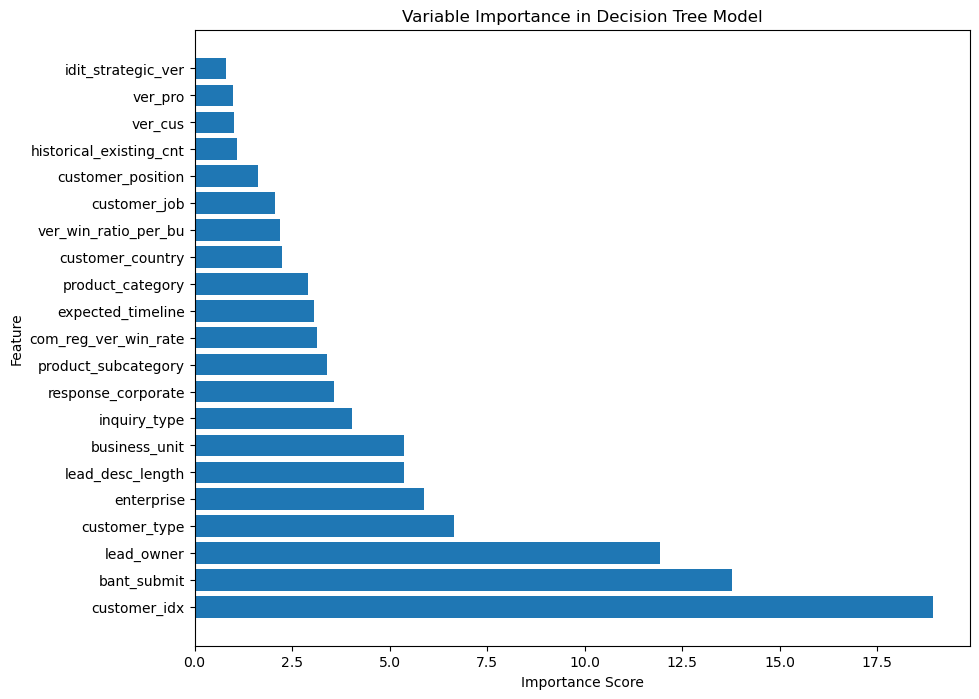

In [15]:
# 변수 중요도 확인
feature_importances = best_model.feature_importances_

# 변수명과 중요도를 매칭
features = x_train.columns
importance_dict = dict(zip(features, feature_importances))

# 중요도를 기준으로 내림차순 정렬
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
sorted_features, sorted_importances = zip(*sorted_importance)

# 시각화
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_features)), sorted_importances, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Variable Importance in Decision Tree Model')
plt.show()


In [20]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [21]:
pred = best_model.predict(x_val)
get_clf_eval(y_val, pred)

오차행렬:
 [[  849   138]
 [  144 10729]]

정확도: 0.9762
정밀도: 0.8550
재현율: 0.8602
F1: 0.8576


In [16]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [17]:
test_pred = best_model.predict(x_test)
sum(test_pred) # True로 예측된 개수

725.0

In [18]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)